In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
figsize = (5.6, 5.6)
import numpy as np
initfontsize=8
import linecache
from obspy.imaging.beachball import beach
from matplotlib.patches import ArrowStyle
from scipy.interpolate import griddata
import matplotlib.patheffects as path_effects
import warnings
warnings.filterwarnings("ignore")
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84
import matplotlib as mpl
cmap = plt.get_cmap('Set2', 8)
from cycler import cycler
custom_color_cycle=[]
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    custom_color_cycle.append(str(mpl.colors.rgb2hex(rgb)))
plt.rc('axes', prop_cycle=(cycler(color=custom_color_cycle)))

import matplotlib as mpl
mpl.rc('axes', labelsize=initfontsize, titlesize=initfontsize)
mpl.rc('xtick', labelsize=initfontsize)
mpl.rc('ytick', labelsize=initfontsize)
mpl.rc('legend', fontsize=initfontsize, edgecolor='none')
mpl.rc('savefig', dpi=600, transparent=False)
mpl.rc('font', size=initfontsize)

mpl.rcParams["font.family"] = "CMU Sans Serif"
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'CMU Sans Serif'
mpl.rcParams['mathtext.it'] = 'CMU Sans Serif:italic'
mpl.rcParams['mathtext.bf'] = 'CMU Sans Serif:bold'


In [178]:
def mapTicks(fig,m,ax,xtickint,ytickint,lonmin,lonmax,latmin,latmax):
    axp=ax.get_position()
    ax2 = fig.add_axes([axp.x0, axp.y0, axp.width, axp.height])

    #xticklabels = np.arange(int(lonmin - lonmin%xtickint), int(lonmax - lonmax%xtickint) + xtickint, xtickint)
    #yticklabels = np.arange(int(latmin - latmin%ytickint), int(latmax - latmax%ytickint) + ytickint, ytickint)

    xticklabels = np.arange(lonmin - lonmin%xtickint, lonmax - lonmax%xtickint + xtickint, xtickint)
    yticklabels = np.arange(latmin - latmin%ytickint, latmax - latmax%ytickint + ytickint, ytickint)
    
    tmp = [m(i, latmin) for i in xticklabels]
    xticks = [tmp[i][0] for i in range(len(xticklabels))]
    ax2.set_xticks(xticks)

    tmp = [m(lonmin, i) for i in yticklabels]
    yticks = [tmp[i][1] for i in range(len(yticklabels))]
    ax2.set_yticks(yticks)

    #tmp = [ str(xticklabels[i])+'$\degree$' for i in range(len(xticklabels)) ]
    tmp = [ str('{:.1f}'.format(xticklabels[i]))+'$\degree$E' if xticklabels[i] > 0 else \
           str('{:.1f}'.format(abs(xticklabels[i])))+'$\degree$W' if  xticklabels[i] < 0 else \
           str('{:.1f}'.format(xticklabels[i]))+'$\degree$' for i in range(len(xticklabels)) ]
    ax2.set_xticklabels(tmp)

    #tmp = [ str(yticklabels[i])+'$\degree$' for i in range(len(yticklabels)) ]
    tmp = [ str('{:.1f}'.format(yticklabels[i]))+'$\degree$N' if yticklabels[i] > 0 else \
           str('{:.1f}'.format(abs(yticklabels[i])))+'$\degree$S' if  yticklabels[i] < 0 else \
           str('{:.1f}'.format(yticklabels[i]))+'$\degree$' for i in range(len(yticklabels)) ]
    ax2.set_yticklabels(tmp)

    xlimmin, ylimmin = m(lonmin, latmin)
    xlimmax, ylimmax = m(lonmax, latmax)
    ax2.set_xlim(xlimmin, xlimmax)
    ax2.set_ylim(ylimmin, ylimmax)
    minZorder=min([_.zorder for _ in ax.get_children()])
    ax2.set_zorder(minZorder-1)

    return ax2

def getSlipCell(slat, slon, dl, dk, stk, dip, m):
    shiftk = dk/2 * np.cos(np.deg2rad(dip))
    shiftl = dl/2

    tmp0 = geod.Direct(slat, slon, stk-90, shiftk*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], stk, shiftl*1e3)
    x, y = m(tmp1['lon2'], tmp1['lat2'])
    rbx, rby = x, y

    tmp0 = geod.Direct(slat, slon, stk-90, shiftk*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], stk-180, shiftl*1e3)
    x, y = m(tmp1['lon2'], tmp1['lat2'])
    rtx, rty = x, y

    tmp0 = geod.Direct(slat, slon, stk+90, shiftk*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], stk-180, shiftl*1e3)
    x, y = m(tmp1['lon2'], tmp1['lat2'])
    ltx, lty = x, y

    tmp0 = geod.Direct(slat, slon, stk+90, shiftk*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], stk, shiftl*1e3)
    x, y = m(tmp1['lon2'], tmp1['lat2'])
    lbx, lby = x, y

    xlist = [lbx, rbx, rtx, ltx, lbx]
    ylist = [lby, rby, rty, lty, lby]
    return xlist, ylist

def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]        
    return h0, model_dip, model_icmn, model_str

def selectplane(modelstk, modeldip, stk0, dip0, rake0, stk1, dip1, rake1):
    vecmodelplane = faultnormalvec(modelstk, modeldip)
    vecplane0 = faultnormalvec(stk0, dip0)
    vecplane1 = faultnormalvec(stk1, dip1)
    tmp0 = np.inner(vecmodelplane, vecplane0)
    tmp1 = np.inner(vecmodelplane, vecplane1)
    if abs(tmp0) > abs(tmp1):
        stk_s = stk0
        dip_s = dip0
        rake_s = rake0
    elif abs(tmp0) < abs(tmp1):
        stk_s = stk1
        dip_s = dip1
        rake_s = rake1
    else:
        stk_s = stk0
        dip_s = dip0        
        rake_s = rake0        
    return stk_s, dip_s, rake_s

def faultnormalvec(stk, dip):
    nn = -np.sin(np.deg2rad(stk)) * np.sin(np.deg2rad(dip))
    ne =  np.cos(np.deg2rad(stk)) * np.sin(np.deg2rad(dip))
    nd = -np.cos(np.deg2rad(dip))
    return np.array([ne, nn, nd])

def plotSlipXY(modelid, arrowflag, axpxinit, axpyinit):
    data=np.loadtxt('model_'+str(modelid)+'/FFM_DCall.txt', skiprows=1)
    x, y, slip, stk0, dip0, rake0 = data[:,11], data[:,12],data[:,4], data[:,5], data[:,6],data[:,7]
    stk1, dip1, rake1 = data[:,8], data[:,9],data[:,10]
    lines=linecache.getlines('model_'+str(modelid)+'/fort.40')
    fort40=np.genfromtxt('model_'+str(modelid)+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
    dx, dy, nx, ny, x0, y0 = fort40[0], fort40[1], fort40[2], fort40[3], fort40[4], fort40[5]
    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(modelid)+'/fort.40')
    #print(h0, model_dip, model_icmn, model_str)
    #print(str(modelid), dx, dy)
    
    cmap=plt.get_cmap('hot_r')    
    #fig=plt.figure(figsize=figsize)
    axw=0.5
    axh=(abs(max(y)-min(y))) / (abs(max(x)-min(x))) * axw
    for panel in [0, 1]:
        ax=fig.add_axes([axpxinit, axpyinit-(axh+0.02)*panel-axh-0.075,axw,axh])
        axp=ax.get_position()
        
        for i in np.arange(0, len(slip), 1):
            tmpx, tmpy = x[i], y[i]
            tmpxlist = [tmpx-dx/2, tmpx+dx/2, tmpx+dx/2, tmpx-dx/2, tmpx-dx/2]
            tmpylist = [tmpy-dy/2, tmpy-dy/2, tmpy+dy/2, tmpy+dy/2, tmpy-dy/2]
            ax.fill(tmpxlist, tmpylist, facecolor=cmap(slip[i]/max(slip)), edgecolor='none', zorder=0)
            
        strike, dip, rake = [],[],[]
        for i in range(len(stk0)):
            tmpstr, tmpdip, tmprake = selectplane(model_str, model_dip, stk0[i], dip0[i], rake0[i], stk1[i], dip1[i], rake1[i])
            strike.append(tmpstr)
            dip.append(tmpdip)
            rake.append(tmprake)

        if model_icmn == 5:
            ax = plt.gca()
            if panel == 0:
                fig.text(axp.x1, axp.y1+0.002, '$\phi=$'+str(model_str)+'$\degree$, $\delta=$'+str(model_dip)+'$\degree$', 
                         va='bottom', ha='right', size=6)
                for i in range(len(strike)):
                    focmecs=[strike[i], dip[i], rake[i]]
                    color=cmap(slip[i]/max(slip))
                    b = beach(focmecs, xy=(x[i], y[i]), width=dx/10*5, linewidth=0.5, facecolor='k', edgecolor='C7', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
            elif panel == 1:
                for i in np.arange(0, len(strike), 1):
                    if arrowflag == 'rake':
                        fig.text(axp.x1, axp.y1+0.002, 'Rake', va='bottom', ha='right', size=6)
                        a=rake[i]*np.pi/180.0
                        length=slip[i] / max(slip) * dx/10.0*10.0
                        x1=np.cos(a)*length
                        y1=np.sin(a)*length
                        #spoint = [x[i], y[i]] # for dip, rake
                        #epoint = [x1+x[i], y1+y[i]]
                        #arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, 
                        #                        head_width=0.4 * slip[i]/max(slip) * 0.5)
                        #ax.annotate('', xy=epoint, xytext=spoint, 
                        #            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.75), annotation_clip=False)
                        #ax.text(x[i], y[i], str('{:.1f}'.format(rake[i])), size=2, va='center', ha='center')
                        #spoint = [x[i]-x1/3, y[i]-y1/3]
                        #ax.annotate('', xy=epoint, xytext=spoint, 
                        #            arrowprops=dict(arrowstyle=arrowstyle, color='r', lw=0.2), annotation_clip=False)
                        ax.plot([x[i], x1+x[i]], [y[i], y1+y[i]], color='C2', lw=0.85, zorder=1000, solid_capstyle='round')
                        x2=np.cos(a-np.deg2rad(150))*length*0.2
                        y2=np.sin(a-np.deg2rad(150))*length*0.2
                        ax.plot([x1+x[i], x1+x2+x[i]], [y1+y[i], y1+y2+y[i]], color='C2', lw=0.85, zorder=1000,solid_capstyle='round')
                        x2=np.cos(a+np.deg2rad(150))*length*0.2
                        y2=np.sin(a+np.deg2rad(150))*length*0.2
                        ax.plot([x1+x[i], x1+x2+x[i]], [y1+y[i], y1+y2+y[i]], color='C2', lw=0.85, zorder=1000,solid_capstyle='round')

                    elif arrowflag == 'strike':
                        fig.text(axp.x1, axp.y1, 'Strike', va='bottom', ha='right', size=6)
                        a=(-strike[i]+90)*np.pi/180.0
                        length=slip[i] / max(slip) * dx/10.0*10.0
                        x1=np.cos(a)*length
                        y1=np.sin(a)*length
                        spoint = [x[i]-x1, y[i]-y1] # for strike
                        epoint = [x1+x[i], y1+y[i]]
                        arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, 
                                                head_width=0.4 * slip[i]/max(slip) * 0.5)
                        ax.annotate('', xy=epoint, xytext=spoint, 
                                    arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.75), annotation_clip=False)
                        #ax.text(x[i], y[i], str('{:.1f}'.format(strike[i])), size=2, va='center', ha='center')

                    elif arrowflag == 'dip':
                        fig.text(axp.x1, axp.y1, 'Dip', va='bottom', ha='right', size=6)
                        a=(dip[i]-180)*np.pi/180
                        length=slip[i] / max(slip) * dx/15.0*10.0
                        x1=np.cos(a)*length
                        y1=np.sin(a)*length
                        spoint = [x[i]-x1, y[i]-y1] # for strike
                        epoint = [x1+x[i], y1+y[i]]
                        arrowstyle = ArrowStyle('->', head_length=0.001, head_width=0.001) # for dip
                        ax.annotate('', xy=epoint, xytext=spoint, 
                                    arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.75), annotation_clip=False)
                        #ax.text(x[i], y[i], str('{:.1f}'.format(dip[i])), size=2, va='center', ha='center')
        if panel == 1:
            ax.scatter(0, 0, s=50, marker='*', facecolor='none', edgecolor='C7', alpha=1, zorder=101, lw=0.7)
            ax.set_xticks(np.arange(-1000, 1000, 20))
            ax.set_xlabel('Strike (km)')
        if panel == 0:
            ax.set_xticklabels('')
        ax.set_xlim(min(x)-dx/2, max(x)+dx/2)
        ax.set_ylim(min(y)-dy/2, max(y)+dy/2)

        ax2 = ax.twinx()
        depmin=h0-np.sin(model_dip*np.pi/180.0)*(min(y)-dy/2)
        depmax=h0-np.sin(model_dip*np.pi/180.0)*(max(y)+dy/2)
        ax2.set_ylim(depmin, depmax)

        if panel == 1:
            ax.set_ylabel('Dip (km)')
            ax2.set_ylabel('Depth (km)')

            cax=fig.add_axes([axp.x1+0.08, axp.y0, 0.01, axp.y1-axp.y0])
            norm=mpl.colors.Normalize(vmin=0, vmax=max(slip))
            cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label='Slip (m)', 
                                         ticks=np.linspace(0, max(slip), 5), format='%.2f')
                    
    #plt.savefig(outputfile, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    
    return ax

In [168]:
def plotModelEdge(dx, dy, nx, ny, x0, y0, model_dip, model_stk, elat, elon, m, ax, zorder):
    shiftk = ((ny-y0)*dy+dy/2) * np.cos(np.deg2rad(model_dip))
    tmp0 = geod.Direct(elat, elon, model_stk-90, shiftk*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk, ((nx-x0)*dx+dx/2)*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='k', solid_capstyle='projecting', zorder=zorder+1)

    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk, ((-x0)*dx+dx/2)*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='k', solid_capstyle='projecting', zorder=zorder+1)

    shiftk = ((y0-1)*dy+dy/2) * np.cos(np.deg2rad(model_dip))
    tmp0 = geod.Direct(elat, elon, model_stk+90, shiftk*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk, ((nx-x0)*dx+dx/2)*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='C7', solid_capstyle='butt', zorder=zorder)

    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk, ((-x0)*dx+dx/2)*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='C7', solid_capstyle='butt', zorder=zorder)

    shiftl = (nx-x0)*dx+dx/2
    shiftk = ((y0-1)*dy+dy/2) * np.cos(np.deg2rad(model_dip))
    tmp0 = geod.Direct(elat, elon, model_stk, shiftl*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk+90, shiftk*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='C7', solid_capstyle='projecting', zorder=zorder)

    shiftk = ((ny-y0)*dy+dy/2) * np.cos(np.deg2rad(model_dip))
    tmp0 = geod.Direct(elat, elon, model_stk, shiftl*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk-90, shiftk*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='C7', solid_capstyle='projecting', zorder=zorder)

    shiftl = (x0-1)*dx+dx/2
    shiftk = ((y0-1)*dy+dy/2) * np.cos(np.deg2rad(model_dip))
    tmp0 = geod.Direct(elat, elon, model_stk-180, shiftl*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk+90, shiftk*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='C7', solid_capstyle='projecting', zorder=zorder)

    shiftk = ((ny-y0)*dy+dy/2) * np.cos(np.deg2rad(model_dip))
    tmp0 = geod.Direct(elat, elon, model_stk-180, shiftl*1e3)
    tmp1 = geod.Direct(tmp0['lat2'], tmp0['lon2'], model_stk-90, shiftk*1e3)
    x1, y1 = m(tmp1['lon1'], tmp1['lat1'])
    x2, y2 = m(tmp1['lon2'], tmp1['lat2'])
    ax.plot([x1, x2], [y1, y2], lw=0.5, color='C7', solid_capstyle='projecting', zorder=zorder)

def plotSlipMap(modelid, axpxinit, axpyinit):
    lines=linecache.getlines('model_'+str(modelid)+'/fort.40')
    fort40=np.genfromtxt('model_'+str(modelid)+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
    elat, elon, edep = fort40[3], fort40[4], fort40[5]
    lines=linecache.getlines('model_'+str(modelid)+'/fort.40')
    fort40=np.genfromtxt('model_'+str(modelid)+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
    dx, dy, nx, ny, x0, y0 = fort40[0], fort40[1], fort40[2], fort40[3], fort40[4], fort40[5]
    h0, model_dip, model_icmn, model_stk=load_setting_fort40('model_'+str(modelid)+'/fort.40')
    data=np.loadtxt('model_'+str(modelid)+'/FFM_DCpreferred.txt', skiprows=1)
    lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
    xloc, yloc = data[:,10], data[:,11]
    cmap=plt.get_cmap('hot_r')
    
    lonmin=elon-2; lonmax=elon+2; latmin=elat-1; latmax=elat+1
    #print(lonmin, lonmax, latmin, latmax)
    m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
              rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
    x, y=m([lonmin, lonmax], [latmin, latmax])
    aspect=max(x)/max(y)
    mapwidth=0.5; mapheight=mapwidth/aspect
    #fig=plt.figure(figsize=figsize)
    ax=fig.add_axes([axpxinit, axpyinit, mapwidth, mapheight])
    axp=ax.get_position()
    fig.text(axp.x1, axp.y1+0.002, '$\phi=$'+str(model_stk)+'$\degree$, $\delta=$'+str(model_dip)+'$\degree$', 
         va='bottom', ha='right', size=6)
    m.fillcontinents(color='C7', zorder=0, alpha=0.1)
    m.drawcoastlines(color='C7', linewidth=0.2, zorder=0)
    
    for i in range(len(lat)):
        xslipcell, yslipcell = getSlipCell(lat[i], lon[i], dx, dy, model_stk, model_dip, m)
        ax.fill(xslipcell, yslipcell, facecolor=cmap(slip[i]/max(slip)), zorder=1, edgecolor='none')

    plotModelEdge(dx, dy, nx, ny, x0, y0, model_dip, model_stk, elat, elon, m, ax, 1)
    
    ax = plt.gca()
    x, y = m(lon, lat)
    for i in range(len(strike)):
        focmecs=[strike[i], dip[i], rake[i]]
        color=cmap(slip[i]/max(slip))
        b = beach(focmecs, xy=(x[i], y[i]), width=dx/10*6000, linewidth=0.15, facecolor='k', edgecolor='C7', \
                  bgcolor='w')
        b.set_zorder(10); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
        #ax.add_collection(b)

    x, y=m(elon, elat)
    ax.scatter(x, y, s=50, marker='*', facecolor='none', edgecolor='C7', alpha=0.85, lw=0.5, zorder=10)
    
    cax=fig.add_axes([axp.x1+0.005, axp.y0, 0.01, axp.y1-axp.y0])
    norm=mpl.colors.Normalize(vmin=0, vmax=max(slip))
    cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label='Slip (m)', 
                                 ticks=np.linspace(0, max(slip), 5), format='%.2f')
    
    ax2 = mapTicks(fig,m,ax,1,0.5,lonmin,lonmax,latmin,latmax)


    #plt.savefig(outputfile, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    return ax, m

In [169]:
def plotMRF(modelid, axpxinit, axpyinit):
    #fig=plt.figure(figsize=figsize)
    ax=fig.add_axes([axpxinit, axpyinit, 0.25, 0.15])
    data=np.loadtxt('model_'+str(modelid)+'/st_'+str(modelid)+'.dat')
    t, amp=data[:,0], data[:,1]
    ax.plot(t, amp, color='k', lw=0.5)
    ax.fill(t, amp, color='C7')
    ax.set_ylabel('Moment rate\n'+r'($\times 10^{18}$ Nm/s)')
    ax.set_xlabel('Time (s)')
    ax.set_ylim([0, max(amp)+0.75])
    #plt.savefig(outputfile, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    return ax

In [224]:
def plotSnap(modelid, snapend, snapint, refVr, outputfile):
    maxsliprateall = np.loadtxt('model_'+str(modelid)+'/snap_1sec_201.txt', usecols=8, skiprows=1)[0]
    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(modelid)+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note_model='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag

    data = np.loadtxt('model_'+str(modelid)+'/tw_mec.dat')
    snap_t, str_total, dip_total, rake_total = data[:,0], data[:,9], data[:,11], data[:,13]
    m1, m2, m3, m4, m5, m6 = data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], data[:,8]

    lines=linecache.getlines('model_'+str(modelid)+'/fort.40')
    fort40=np.genfromtxt('model_'+str(modelid)+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
    dx, dy, nx, ny, x0, y0 = fort40[0], fort40[1], fort40[2], fort40[3], fort40[4], fort40[5]

    fig=plt.figure(figsize=figsize)
    snapnum = 0
    for snap in np.arange(1, snapend+snapint, snapint):
        #print(snap)
        data=np.loadtxt('model_'+str(modelid)+'/snap_1sec_'+str(200+snap)+'.txt', skiprows=1)
        x, y, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

        mecadata=np.loadtxt('model_'+str(modelid)+'/snap_1sec_meca_'+str(200+snap)+'.txt', skiprows=1)
        str_t, dip_t, rake_t=mecadata[:,9], mecadata[:,11], mecadata[:,13]
        
        xi=np.linspace(min(x)-dx/2, max(x)+dx/2, 100)
        yi=np.linspace(min(y)-dy/2, max(y)+dy/2, 100)
        
        X, Y=np.meshgrid(xi, yi)
        zi=griddata((x, y), avesliprate, (X, Y),'linear')
        interval=np.linspace(0, maxsliprateall, 21)
        
        axw=0.5
        axh=(max(yi)-min(yi)) / (max(xi)-min(xi)) * axw
        xloc=0.1
        if snap == 1:
            yloc = 0.1
        elif snap >= 2:
            yloc=axp.y1 + 0.01

        ax=fig.add_axes([xloc,yloc,axw,axh])
        axp=ax.get_position()
        note=str(data[0:1,6][0])+'–'+str(data[0:1,7][0]) + ' s'
        text=fig.text(axp.x0+0.01, axp.y1-0.01, note, va='top', ha='left', size=8)
        text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxsliprateall, cmap='hot_r')

        if model_icmn == 5:
            cmap=plt.get_cmap('hot_r')
            ax = plt.gca()
            for i in range(len(str_t)):
                focmecs=[str_t[i], dip_t[i], rake_t[i]]
                color=cmap(avesliprate[i]/maxsliprateall)
                b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.5, facecolor='k', edgecolor='k', bgcolor='w')
                b.set_zorder(1); b.set_alpha(avesliprate[i]/maxsliprateall); b.set_clip_on(False)
                #ax.add_collection(b)
        elif model_icmn == 2:
            for k in np.arange(0, len(str_t), 1):
            #    #a=0.5*np.pi - strike[k]*np.pi/180.0
                a=rake_t[k]*np.pi/180.0
                length=avesliprate[k]/0.5*20
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                ax.arrow(x[k], y[k], x1, y1, linewidth=0.5, head_width=1, head_length=1, overhang=-0.1, \
                         color='C0', clip_on=False, alpha=avesliprate[k]/maxsliprateall)

        #for vr in np.arange(3, 7, 1):
        vr = refVr
        az = np.arange(-np.pi, np.pi, 0.01)
        x = np.cos(az) * data[0:1,7][0] * vr
        y = np.sin(az) * data[0:1,7][0] * vr
        ax.plot(x, y, color='C7', lw=0.5, alpha=0.85)
        
        if snapnum == 1:
            x = np.cos(0) * data[0:1,7][0] * vr
            y = np.sin(0) * data[0:1,7][0] * vr - dy
            text=ax.text(x, y, str(vr)+' km/s', alpha=0.5, size=4, 
                 color='k', ha='left', va='center', zorder=10)     
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.5), path_effects.Normal()])

        #if snap == 10:
        #    if vr == 6:
        #        text=ax.text(np.cos(0) * data[0:1,7][0] * vr +1, np.sin(0) * data[0:1,7][0] * vr, \
        #                     str(vr)+' km/s', size=8, color='C7')
        #        text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
        #    else:
        #        text=ax.text(np.cos(0) * data[0:1,7][0] * vr +1, np.sin(0) * data[0:1,7][0] * vr, \
        #                     str(vr), size=8, color='C7')
        #        text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
        
        ax2 = ax.twinx()
        depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
        depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
        #ax2.set_yticks(np.arange(-5, 40, 10))
        ax2.set_ylim(depmin, depmax)
        if snap == 1:
            ax2.set_ylabel('Depth (km)')
            ax.set_xlabel('Strike (km)')
            ax.set_ylabel('Dip (km)')
            axp0=ax.get_position()
        else:
            ax.set_xticklabels([])
            ax2.set_yticklabels([])
            ax.set_yticklabels([])
        ax.set_xlim(min(xi), max(xi))
        ax.set_ylim(min(yi), max(yi))

        ax.scatter(0, 0, s=50, marker='*', facecolor='none', edgecolor='C7', alpha=1, zorder=101, lw=0.7)
        
        axheight = (axp.y1-axp.y0)*0.35
        axwidth = axheight
        axb = fig.add_axes([axp.x1+0.07, axp.y0+(axp.y1-axp.y0-axheight)/2, axwidth, axheight])
        axbp = axb.get_position()
        fig.text(axbp.x0+(axbp.x1-axbp.x0)/2, axbp.y1+0.01, 'Total', size=6, ha='center', va='bottom')
        focmecs=[str_total[snap-1], dip_total[snap-1], rake_total[snap-1]]
        #focmecs=[m1[snap-1], m2[snap-1], m3[snap-1], m4[snap-1], m5[snap-1], m6[snap-1]]
        color=cmap(np.max(avesliprate)/maxsliprateall)
        b = beach(focmecs, xy=(0.5, 0.5), width=np.max(avesliprate)/maxsliprateall, linewidth=1, facecolor=color, edgecolor='k', bgcolor='w')
        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
        axb.add_collection(b)
        axb.set_xticks([])
        axb.set_yticks([])
        axb.spines['top'].set_visible(False)
        axb.spines['right'].set_visible(False)
        axb.spines['bottom'].set_visible(False)
        axb.spines['left'].set_visible(False)
        
        snapnum += 1
    
    cax=fig.add_axes([axp0.x1+0.15, axp0.y0, 0.01, axp0.height])
    norm=mpl.colors.Normalize(vmin=0, vmax=maxsliprateall)
    cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label='Slip rate (m)', 
                                 ticks=np.linspace(0, maxsliprateall, 3), format='%.3f')

    fig.text(axp.x1, axp.y1, '$\phi=$'+str(model_str)+'$\degree$, $\delta=$'+str(model_dip)+'$\degree$', 
         va='bottom', ha='right', size=6)

    plt.savefig(outputfile, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [181]:
def drawobssyn(ax, obsdata, syndata, alpha):
    data=np.loadtxt(obsdata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C7', lw=0.2, alpha=alpha)
    data=np.loadtxt(syndata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C3', lw=0.2, alpha=alpha)
def fittings(sta, x0, y1, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, flag, azi, dis):
    j=0
    for i in np.arange(0, len(modelid), 1):
        ax=fig.add_axes([x0,y1-height*j,width,height])
        drawobssyn(ax, 'model_'+modelid+'/obssyn/obs_'+sta+'.txt', \
                   'model_'+modelid+'/obssyn/syn_'+sta+'.txt', 0.85)
        cmap=plt.get_cmap('RdYlBu')
        color = cmap(dep[i]/maxdepofcolor)
        if flag == 1:
            ax.scatter(mint, 0, s=20, marker='*', edgecolor='C7', lw=0.3, zorder=20, color=color, clip_on=False)
            #ax.text(-5, -0.3, r'$h_{0}$='+str('%.1f' % dep[i]), ha='left', va='top', size=6, color='C7')
        ax.set_xlim([mint, maxt])
        ax.set_ylim([-1, 1])
#        ax.plot([0, 0],[-1, 1], lw=0.1)
        if i==0:
            ax.text(mint, 1, sta+'\nAz.='+str(azi)+'$\degree$\nDel.='+str(dis)+'$\degree$', \
                    va='bottom', ha='left', size=6, color='C7', clip_on=False)
        #if i==numwave-1:
        if i==12:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([0, 30, 60])
            ax.set_xticklabels([0, 30, 60], size=6)
            ax.set_xlabel('Time (s)', size=6)
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([])
        j+=1
    return ax, cmap

def plotFit(modelid, outputfile):
    w = 7.4; h = 7.4; wh=w/h
    fig=plt.figure(figsize=(w, h))
    alpha=0.85
    axw=0.3
    axh=0.1
    stalist=np.loadtxt('model_'+str(modelid)+'/station_'+str(modelid)+'.list', usecols=(0), dtype=str)
    stadata=np.loadtxt('model_'+str(modelid)+'/station_'+str(modelid)+'.list', usecols=(4, 5))
    datalen = np.loadtxt('model_'+str(modelid)+'/'+str(modelid)+'.station.abic', skiprows=1, usecols=5)
    #datalen = np.loadtxt('.station.abic', skiprows=1, usecols=5)
    maxdatalen = max(datalen)
    azi, dis=(stadata[:,0], stadata[:,1])
    for i in np.arange(0, len(stalist), 1):
        num = 10
        mod = i // num
        if i == 0:
            ax=fig.add_axes([0.1, 0.1, axw, axh])
            axp=ax.get_position()
            axp0=ax.get_position()
            #fig.text(axp.x0, axp.y1+0.03, str(pwd)+', '+modelid, va='bottom', ha='left')
        elif i == num*(mod):
            ax=fig.add_axes([axp0.x1+axw*(mod-1)+0.01*(mod), axp0.y0, axw, axh])
            axp=ax.get_position()
        elif i > num*(mod) and i < num*(mod+1):
            ax=fig.add_axes([axp.x0, axp.y0-axh, axw, axh])
            axp=ax.get_position()

        if i == num*(mod+1)-1:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            #ax.set_xticks(np.arange(0, 80, 20))
            #ax.set_xticklabels(np.arange(0, 80, 20), size=8)
            ax.set_xlabel('Time (s)', size=8)
            ax.set_yticklabels([])
            ax.set_yticks([])
            axpbottom = ax.get_position()
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([]) 

        sta=stalist[i]
        obsdata='model_'+str(modelid)+'/obssyn/obs_'+sta+'.txt'
        syndata='model_'+str(modelid)+'/obssyn/syn_'+sta+'.txt'

        data=np.loadtxt(obsdata, usecols=(0, 1))
        t, amp=(data[:,0]-5, data[:,1])
        ax.plot(t, amp, color='k', lw=1.4, alpha=alpha)
        data=np.loadtxt(syndata, usecols=(0, 1))
        t, amp=(data[:,0]-5, data[:,1])
        ax.plot(t, amp, color='r', lw=1.4, alpha=0.7)
        fig.text(axp.x1-0.06, axp.y1+0.02, sta+'\nAz.='+str(azi[i])+'$\degree$\nDel.='+str(dis[i])+'$\degree$', \
                            va='top', ha='left', size=6, color='k', clip_on=False, alpha=alpha)
        ax.set_ylim([-1.2, 1.2])
        ax.set_xlim([-5, maxdatalen])
        
    ax=fig.add_axes([axp.x1+0.05, axpbottom.y0, 0.35, 0.35])
    axp=ax.get_position()
    sc = aziequi(ax, 'model_'+str(modelid)+'/station_'+str(modelid)+'.list')

    plt.savefig(outputfile, bbox_inches="tight", pad_inches=0.1)
    plt.show()

In [194]:
def aziequi(ax, stalist):
    data = np.loadtxt(stalist, usecols=(5, 4))
    d, a = (data[:, 0], 90-data[:,1])
    x, y=(d*np.cos(a*np.pi/180.0), d*np.sin(a*np.pi/180.0))
    sc=ax.scatter(x, y, s=8, marker='^', edgecolor='none', facecolor='r', alpha=0.85, zorder=10)
    sc=ax.scatter(x, y, s=8, marker='^', edgecolor='k', facecolor='none', alpha=1, lw=0.5, zorder=10)
    stalist=np.loadtxt(stalist, usecols=(0), dtype=str)
    #print(stalist)
    #for (i, staname) in enumerate(stalist):
        #text = ax.text(x[i], y[i], staname, size=10, va='center')
        #text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.85), path_effects.Normal()])
    ax.scatter(0, 0, s=100, marker='*', edgecolor='k', facecolor='none')
    theta=np.linspace(0, 360, 360)
    for i in [30, 90]:
        x, y=(i*np.cos(theta*np.pi/180.0), i*np.sin(theta*np.pi/180.0))
        ax.plot(x, y, color='C7', zorder=0, solid_capstyle='round', lw=1, linestyle='--')
        x, y=(i*np.cos(-90*np.pi/180.0), i*np.sin(-90*np.pi/180.0))
        text = ax.text(x, y, str(i)+'$\degree$', size=6, va='center', ha='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

    x, y=(100*np.cos(theta*np.pi/180.0), 100*np.sin(theta*np.pi/180.0))
    ax.plot(x, y, color='k', solid_capstyle='round', lw=1)
    ax.fill(x, y, edgecolor='none', facecolor='w', zorder=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([]) 
    return sc

def plotStation(modelid, axpxinit, axpyinit):
    #fig=plt.figure(figsize=figsize)
    ax=fig.add_axes([axpxinit, axpyinit, 0.2, 0.2])
    axp=ax.get_position()
    sc = aziequi(ax, 'model_'+str(modelid)+'/station_'+str(modelid)+'.list')
    #sc = aziequi(ax, 'station.list')

    #plt.savefig('fitting_'+str(model[k])+'.png', bbox_inches="tight", pad_inches=0.1)
    #plt.savefig('station_'+str(model[k])+'.pdf', bbox_inches="tight", pad_inches=0.1)
    #plt.savefig(outputfile, bbox_inches="tight", pad_inches=0.1)
    #plt.show()
    return ax

In [188]:
def loadInfo(modelid):
    lines=linecache.getlines('model_'+str(modelid)+'/fort.40')
    fort40=np.genfromtxt('model_'+str(modelid)+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
    moment, mw, elat, elon, edep = fort40[0], fort40[1], fort40[2], fort40[3], fort40[4]

    fort40=np.genfromtxt('model_'+str(modelid)+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
    variance = fort40[0]

    return moment, mw, elat, elon, edep, variance

In [236]:
def plotTimeEvo(modelid, vr, outputfile):
    h0, model_dip, model_icmn, model_stk=load_setting_fort40('model_'+str(modelid)+'/fort.40')

    data=np.loadtxt('model_'+str(modelid)+'/slip-rate-time_along_strike.txt', skiprows=1)
    t, x, amp = data[:,0], data[:,1], data[:,3]
    xs=np.linspace(min(x), max(x), 1000)
    ys=np.linspace(min(t), max(t), 1000)
    X, Y = np.meshgrid(xs, ys)
    Z = griddata((x, t), amp, (X, Y),'linear')
    levels = np.linspace(0, max(amp), 21)

    fig=plt.figure(figsize=figsize)
    ax=fig.add_axes([0.1, 0.1, 0.5, 0.3])
    axp=ax.get_position()
    fig.text(axp.x1, axp.y1+0.002, '$\phi=$'+str(model_stk)+'$\degree$', 
         va='bottom', ha='right', size=6)

    cmap='hot_r'
    sc = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, vmin=0, vmax=max(amp))
    
    '''
    pick_t = []
    pick_x = []
    for j in np.arange(0, np.max(t), 1):
        tmpamp = [amp[i] for i in range(len(amp)) if t[i] == j]
        tmpx = [x[i] for i in range(len(amp)) if t[i] == j]
        tmpt = [t[i] for i in range(len(amp)) if t[i] == j]
        pick_t.append(tmpt[0])
        pick_x.append(tmpx[np.argmax(tmpamp)])
    ax.plot(pick_x, pick_t, color='C0', label='Slip-rate ridge', lw=0.5)
    ax.legend(loc='lower left', fontsize=4)
    '''

    xloc = np.max(x)
    x0, x1 = 0, xloc
    y0, y1 = 0, abs((x1-x0)/vr)
    ax.plot([x0, x1], [y0, y1], color='C7', lw=1, alpha=0.5)
    text=ax.text(xloc/2, abs((xloc/2-x0)/vr), str(vr)+' km/s', alpha=0.5, size=4, 
                 color='k', ha='left', va='center', zorder=10)     
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.5), path_effects.Normal()])

    xloc = np.min(x)
    x0, x1 = 0, xloc
    y0, y1 = 0, abs((x1-x0)/vr)
    ax.plot([x0, x1], [y0, y1], color='C7', lw=1, alpha=0.5)
    text=ax.text(xloc/2, abs((xloc/2-x0)/vr), str(vr)+' km/s', alpha=0.5, size=4, 
                 color='k', ha='right', va='center', zorder=10)     
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.5), path_effects.Normal()])
    
    ax.set_xlabel('Strike (km)')
    ax.set_ylabel('Time (s)')
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(0, max(t)+1)
    axp=ax.get_position()

    cax=fig.add_axes([axp.x1+0.005, axp.y0, 0.01, axp.y1-axp.y0])
    norm=mpl.colors.Normalize(vmin=0, vmax=max(amp))
    cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label='Slip rate (m/s)', 
                                 ticks=np.linspace(0, max(amp), 5), format='%.3f')
    
    plt.savefig(outputfile, bbox_inches="tight", pad_inches=0.1)
    plt.show()

5.423e+19 7.09 38.64 37.888 26.834 0.37126


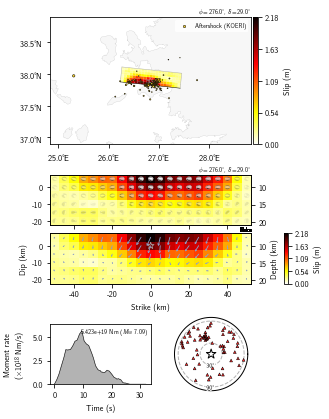

5.62e+19 7.1 41.85 37.888 26.834 0.38379


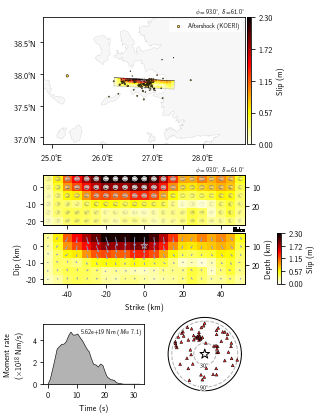

In [244]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for j in [0,1]:
    fig=plt.figure(figsize=figsize)

    ax, m =plotSlipMap(model[j], 0.1, 0.1)
    data = np.loadtxt('koeri.txt', usecols=(2,4,6))
    x, y = m(data[:,2], data[:,1])
    ax.scatter(x, y, s=5*np.exp(data[:,0]) / 150, marker='o', facecolor='C5', 
               edgecolor='k', alpha=1, zorder=105, lw=0.5, label='Aftershock (KOERI)')
    ax.legend(loc='upper right', fontsize=6)
    
    axp=ax.get_position()
    ax=plotSlipXY(model[j], 'rake', axp.x0, axp.y0)
    axp=ax.get_position()
    ax=plotMRF(model[j], axp.x0, axp.y0-0.25)
    axp=ax.get_position()
    moment, mw, elat, elon, edep, variance = loadInfo(model[j])
    print(moment, mw, elat, elon, edep, variance)
    fig.text(axp.x1-0.005, axp.y1-0.005, str(moment)+' Nm ($M_{\mathrm{W}}$ '+str(mw)+')', size=6, va='top', ha='right')
    
    ax=plotStation(model[j], axp.x1+0.05, axp.y0-0.025)
    axp=ax.get_position()

    plt.savefig('fig/summary_'+str(model[j])+'.png', bbox_inches="tight", pad_inches=0.1)
    plt.show()

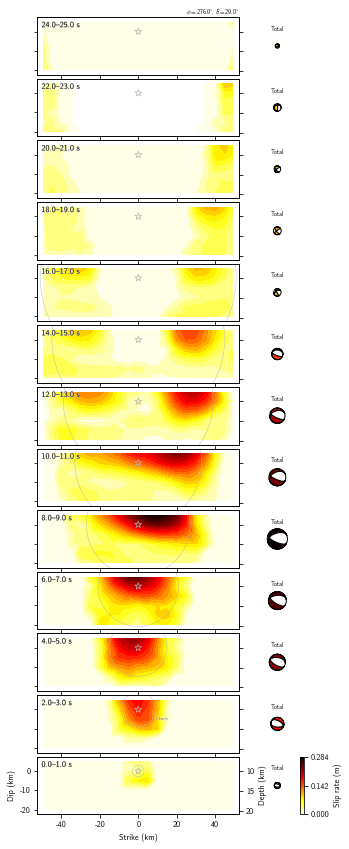

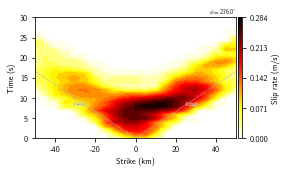

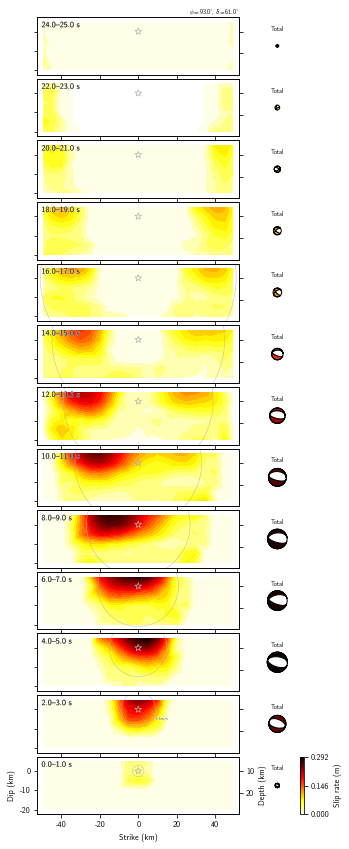

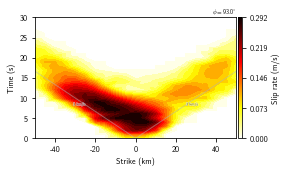

In [245]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for j in [0,1]:
    plotSnap(model[j], 25, 2, 3, 'fig/snap_'+str(model[j])+'.png')
    plotTimeEvo(model[j], 3, 'fig/evo_'+str(model[j])+'.png')
    #plotFit(model[j], 'fig/fit_'+str(model[j])+'.pdf')